# Time Series Modeling #
In this project, I will use several different techniques to create the forecasting model. Given that ARIMA model is great at dealing data with apparent trend, I will first try the SARIMA model, using auto-ARIMA function. Next, because there are apparent seasonality and peaks in the time series, I will also try a LSTM model. Lastly, I will try the FB Prophet model, If all models eventually show some different strengths, I would create an FB Prophet ensemble model that takes the prediction (output) of the previous SARIMA model or LSTM model into account as additional regressors. By doing so, I hope the esemble model could pick up the advantages of all models. Yet, if only one of the models performs well, I would use one model only and discard the bad ones.

In [1]:
import pandas as pd
import numpy as np
import math
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima import model_selection
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
import itertools
import os
os.getcwd()
os.chdir('/Users/haochunniu/Desktop/Kaggle Compatition/NY Taxi Demand forecast/Raw Data')

### Read in raw data ###
After reading the raw data in, to make time-series model work, I need to make sure all date frames are stored with datetime index.

In [2]:
raw = pd.read_csv('2016_Jan-Mar_Time_Series.csv')
raw.set_index(['index'],inplace=True)
raw.index = pd.to_datetime(raw.index)

### Time-based train test data split
In order to verify the models, I will use the **last 20% of the data as test data (437 rows) and first 80% as the train data (1748 rows). In addition, while training the FB Prophet model, I will use the built-in time-based cross-validation method to tune the hyperparameters.**  
  
**Train Data time range: 2016-01-01 00:00:00~2016-03-13 19:00:00**  
**Test Data time range: 2016-03-13 00:20:00~2016-04-01 00:00:00**

In [3]:
train = raw.iloc[:1748,:]
test = raw.iloc[1748:,:]

### ARIMA model ###
In order to find the proper **p,d,q,s** for the ARIMA model, I will use different plots and test, such as ACF and PACF to find the proper ranges for the parameters. First, we use the **Dicky Fuller Test** to check **data's stationary**.

In [4]:
#Perform ADF Test
#Null Hypothesis: Data is stationary
#Alternate Hypothesis: Data is not stationary

p_value=adfuller(raw.cnt)[1]
print('Pvalue = {}'.format(p_value))
if p_value<=0.05:
    print('Given that P-value is less than 0.05, I reject the Null Hypothesis and believe that the data is not stationary.')
else:
    print('Given that P-value is no less than 0.05, I do not reject the Null Hypothesis and believe that the data is stationary.')


Pvalue = 0.00019457040861690922
Given that P-value is less than 0.05, I reject the Null Hypothesis and believe that the data is not stationary.


The ACF plot is a good place to observe the **MA (Moving Average) element of the ARIMA model**. According to the ACF plot, I could not identify a clear cutoff. Hence, there's definitely some degree of AR element among the data. In addition, it looks like there's also an apparent seasonality with period around 25. In general, with this plot, I would set the range of MA between **1 to 5**.

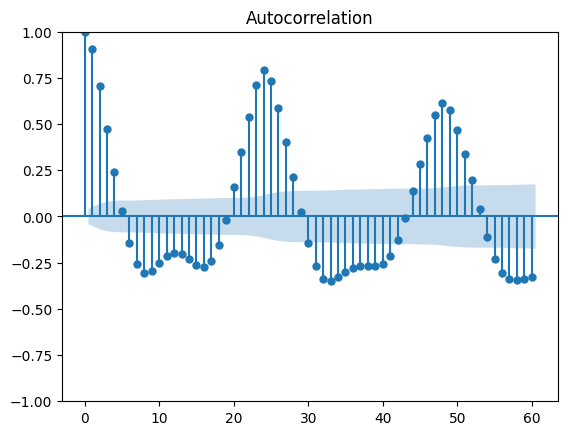

In [5]:
#ACF Plot
plot_acf(raw, lags=60)
print()

The PACF plot is a good place to observe the **AR (Auto Regressive) element of the ARIMA model**. According to the PACF plot, I could identify a clear cutoff around lag 5. Besides, it looks like there's also an apparent seasonality with period around 25. In general, with this plot, I would set the range of AR between **1 to 5**.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


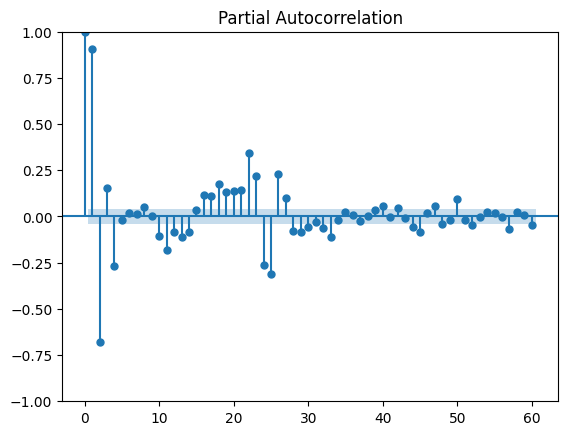

In [6]:
#ACF Plot
plot_pacf(raw, lags=60)
print()

Lastly, in order to identify the seasonality, I going to plot out the time series to estimate the seasonality period. According to the plot, **the peak clearly appears every 20 to 25 periods.** Thus, I would set the seasonality period between **20 to 25**.

<AxesSubplot:xlabel='index'>

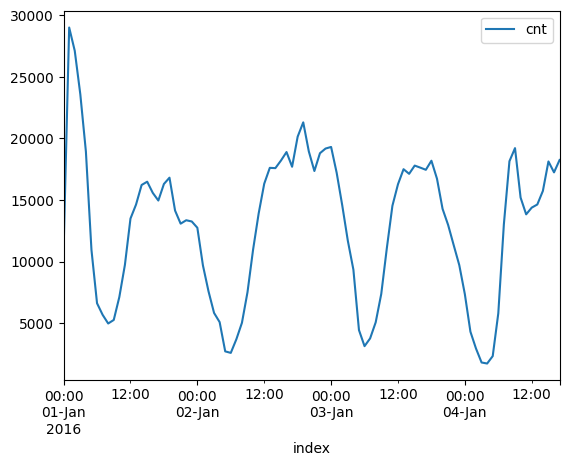

In [7]:
raw[:90].plot()


After finding and defining the ranges for parameters (P,D,Q,S) of SARIMA model, I will start fitting the SARIMA model with the auto-ARIMA function. In the auto-ARIMA function, I could define the ranges of the parameters the model would try. Hence, all the analyses above is fou   
  
**P: 1~5**  
**D: 0~2**  
**Q: 1~5**  
**S: 20~25**  


In [9]:
# Use auto-ARIMA to find and fit the best model
sarima_model = pm.auto_arima(train,
                             start_p=5,max_p=10,
                             start_P=1,max_P=2,
                             start_q=5,max_q=10,
                             start_Q=1,max_Q=2,
                             d=1,
                             seasonal=True,
                             m=25, # m = number of units within each seasonality season
                             random_state=99
                             )

In [106]:
# Summary of the model
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1748
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 25)   Log Likelihood              -15930.850
Date:                              Tue, 27 Dec 2022   AIC                          31871.701
Time:                                      11:57:38   BIC                          31899.029
Sample:                                  01-01-2016   HQIC                         31881.804
                                       - 03-13-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9960      0.003   -390.028      0.000      -1.001      -0.991
ma.L1          1.7055      0.014    124.413      0.000       1.679       1.732
ma.L2          0.7150      0.014     52.430      0.000       0.688       0.742
ma.S.L25       0.4026      0.020     20.425      0.000       0.364       0.441
sigma2      4.851e+06   2.69e-10    1.8e+16      0.000    4.85e+06    4.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               525.81
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.10
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+31. Standard errors may be unstable.
"""

Next, in order to see how good the model is, I will use the model, predict on the test data, and plot out the result. According to the plot, the model is **not doing a good job**.   
   
**1. The MSE of the test data is which is pretty large.**   
**2. According to the plot, it could not capture the peaks of the time series properly.**   
**3. SARIMA model is not good at handling long-term prediction, because the MA parts will eventually drop to 0, and the forecast will get closer and closer to mean.**  
   
Hence, the SARIMA model is probably not a suitable model for this project. In the next step, I am going to try the **LSTM** model, using the **time-based cross-validation technique**.

RMSE on test data: 7291.397906814548


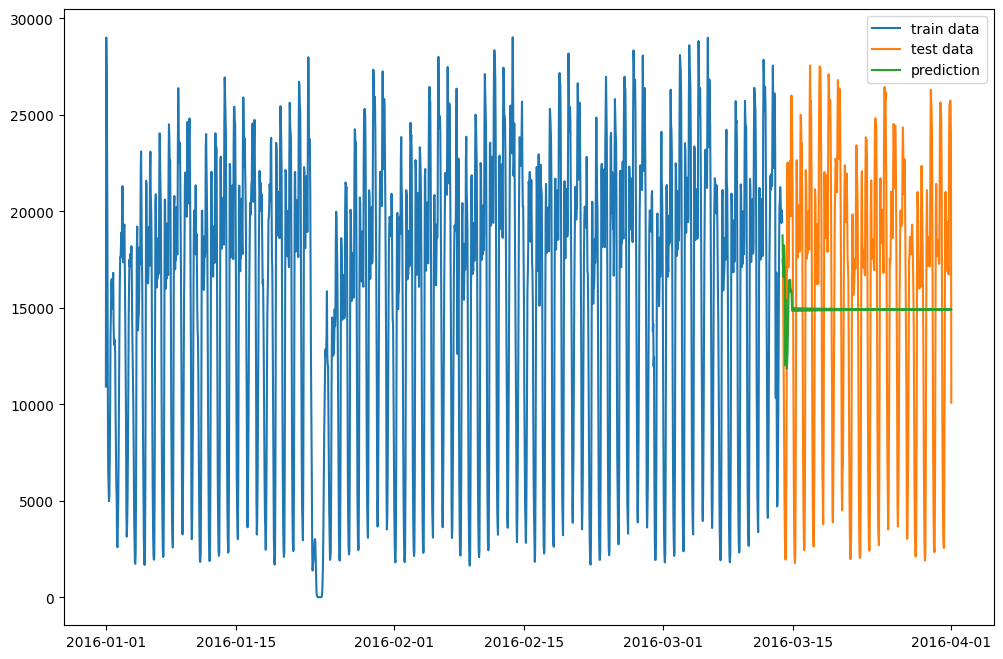

In [107]:
test_pred = sarima_model.predict(n_periods=len(test))
print('RMSE on test data: {}'.format(math.sqrt(mean_squared_error(test,test_pred))))
plt.figure(figsize=(12,8))
plt.plot(train,label='train data')
plt.plot(test,label='test data')
plt.plot(test_pred,label='prediction')
plt.legend()
plt.show()

### LSTM model ###
Next, I will try the LSTM deep learning model. In this section, I start to build the LSTM time series model, using Tensorflow. In order to feed into LSTM, I need to format the train dataset into a sepcific format. Below shows the sample format of a LSTM model input. After formating the input into right format, I will use **random search** to help me find the best hyper-parameter combinations for the LSTM model.   
    
**Ex:**   
5 days' sales time series [11,17,18,21,22]  
LSTM model taking previous **2** periods into account while predicting
  
There will be two important inputs, **X and Y**.
  
X -> [[11,17],[17,18],[18,21]]  
Y -> [18,21,22]  
  
   
----------------------------------------------------------------------------------------------------------------------------------------------------
The entire process could be concluded into the following steps.

**Step1: Create the function to reshape the input data for LSTM model**  
**Step2: Reshape the input time series**  
**Step3: Import all packages for the LSTM model**   
**Step4: Random search on LSTM model to find the best hyper-parameters**  
**Step5: Build and fit the final LSTM model with the best hyper-parameters** 

In [8]:
import tensorflow
import random
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch

/var/folders/6g/vz0p8qdj36g5q9_w2fd7gcs00000gn/T/ipykernel_75492/3903038793.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [9]:
#Step1: Create a function to transform the original time series into LSTM input format
def create_dataset(dataset, look_back):
    # In order to format the dataset into the right format for the LSTM model, I create a function to reform the dataset.
    # param dataset: dataframe used for the model
    # param look_back: number of previous time periods used in the model for each time stamp
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [10]:
#Step2: Reshape the time series into the format
#Given that we have enough time series, we first try look_back period as 100
look_back = 100
n_features = 1
trainX, trainY = create_dataset(train['cnt'], look_back)
testX, testY = create_dataset(test['cnt'], look_back)

#Reshape the X input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back,n_features))
testX = np.reshape(testX, (testX.shape[0], look_back, n_features))

In [20]:
#Step3: Import the packages for LSTM model
import keras
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [27]:
#Step4-1-1: Turn the simple 1 layer LSTM model structure into an random search
#Create the NN structure
def build_model(hp):
    model1 = keras.Sequential()
    model1.add(LSTM(units=hp.Int('units',
                                 min_value=look_back-30,
                                 max_value=look_back,
                                 step=10),
                    activation=keras.activations.ReLU(max_value=hp.Int('max_value',
                                                                       min_value=1000,
                                                                       max_value=3000,
                                                                       step=500)),
                    #return_sequences=True,
                    input_shape=(look_back, n_features),
                    dropout=0.2))
    model1.add(layers.Dense(1,activation='linear'))
    model1.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',[0.01,0.05,0.1])),
                   loss='mse',
                   metrics=['mse'])
    return model1

tuner=RandomSearch(build_model,
                   objective='mse',
                   max_trials=5,
                   executions_per_trial=1,
                   overwrite=True) #Remember to set overwrite = True so we can tune multiple times

#Step4-1-2: Start the random search
random.seed(99)
tuner.search(x=trainX,y=trainY,epochs=400,batch_size=128,validation_data=(testX,testY))

#Step4-1-3: Result of the tuner
result=tuner.get_best_hyperparameters()[0].values
print('The best 1 layer NN parameters would be {} neurons, {} as max value for ReLu activation, and {} learning rate.'.format(result['units'],result['max_value'],result['learning_rate']))
print('------------------------------------------')
print(tuner.results_summary())

Trial 5 Complete [00h 10m 48s]
mse: 17606082.0

Best mse So Far: 6805393.5
Total elapsed time: 01h 00m 39s
INFO:tensorflow:Oracle triggered exit
The best 1 layer NN parameters would be 100 neurons, 1000 as max value for ReLu activation, and 0.01 learning rate.
------------------------------------------
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 100
max_value: 1000
learning_rate: 0.01
Score: 6805393.5
Trial summary
Hyperparameters:
units: 70
max_value: 1000
learning_rate: 0.01
Score: 7574568.5
Trial summary
Hyperparameters:
units: 100
max_value: 3000
learning_rate: 0.05
Score: 12142255.0
Trial summary
Hyperparameters:
units: 70
max_value: 1500
learning_rate: 0.1
Score: 17606082.0
Trial summary
Hyperparameters:
units: 90
max_value: 1000
learning_rate: 0.05
Score: 32832812.0
None


14/14 [==============================] - 0s 16ms/step



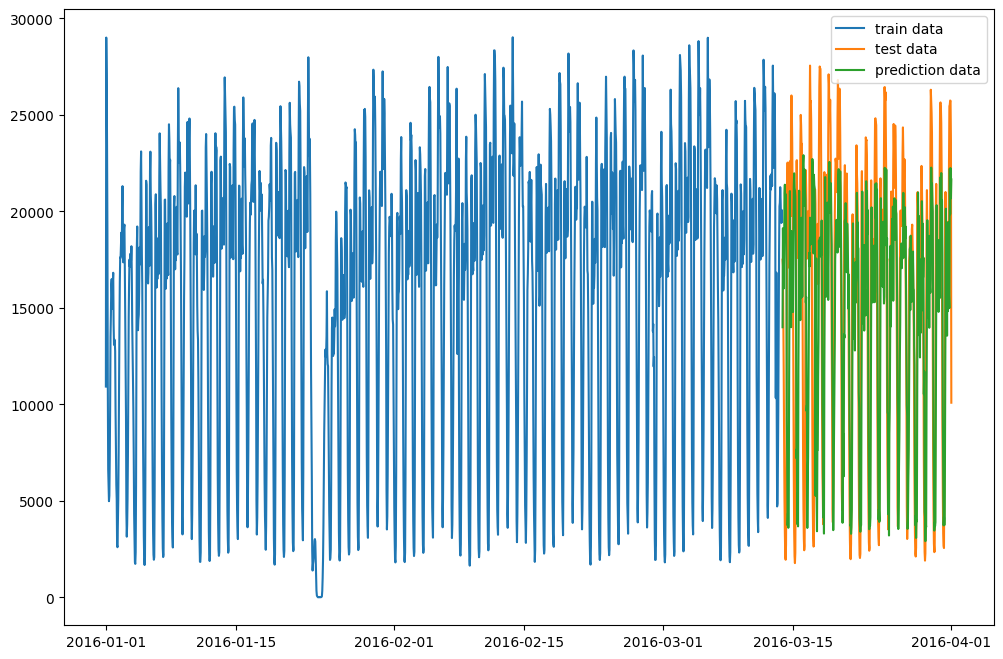

RMSE on validation data: 6705.636415209704


In [28]:
#Step4-1-4: Define the final LSTM model
#This is a 1 layer LSTM model
model_final = tuner.get_best_models(num_models=1)[0]
model_final.fit(trainX, trainY, epochs=400, batch_size=128, verbose=0)

#Step4-1-5: Veification the final model on validation data
#Because the model looks back 60 time periods, we need the last 100 rows of train data to predict the first 100 rows of test data.
tem=trainX[-101:]
new_testX=np.concatenate((tem,testX),axis=0)

testY_predict=model_final.predict(new_testX)
testY_predict=[ i[0] for i in testY_predict]
print()
plt.figure(figsize=(12,8))
plt.plot(train,label='train data')
plt.plot(test,label='test data')
plt.plot(pd.Series(testY_predict,index=test.index),label='prediction data')
plt.legend()
plt.show()

#Step4-1-5: Calculate the MSE
import math
test_rmse=math.sqrt(mean_squared_error(test,testY_predict))
print('RMSE on validation data: {}'.format(test_rmse))

In [32]:
#Step4-2-1: Turn the simple 2 layers LSTM model structure into an random search
#Create the NN structure
def build_model(hp):
    model2 = keras.Sequential()
    model2.add(LSTM(units=hp.Int('units',
                                 min_value=10,
                                 max_value=look_back,
                                 step=10),
                    activation=keras.activations.ReLU(max_value=hp.Int('max_value',
                                                                       min_value=1000,
                                                                       max_value=3000,
                                                                       step=500)),
                    return_sequences=True,
                    input_shape=(look_back, n_features),
                    dropout=0.2))
    model2.add(LSTM(units=hp.Int('units',
                                 min_value=10,
                                 max_value=look_back,
                                 step=10),
                    activation=keras.activations.ReLU(max_value=hp.Int('max_value',
                                                                       min_value=1000,
                                                                       max_value=3000,
                                                                       step=500)),
                    dropout=0.2))
    model2.add(layers.Dense(1,activation='linear'))
    model2.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',[0.01,0.05,0.001])),
                   loss='mse',
                   metrics=['mse'])
    return model2

tuner2=RandomSearch(build_model,
                   objective='mse',
                   max_trials=5,
                   executions_per_trial=1,
                   overwrite=True) #Remember to set overwrite = True so we can tune multiple times

#early_stopping = EarlyStopping(monitor="val_mse",patience=10)

#Step4-2-2: Start the random search
random.seed(999)
tuner2.search(x=trainX,y=trainY,epochs=400,batch_size=128,validation_data=(testX,testY))

#Step4-2-3: Result of the tuner
result2=tuner2.get_best_hyperparameters()[0].values
print('The best 2 layers NN parameters would be {} neurons, {} as max value for ReLu activation, and {} learning rate.'.format(result2['units'],result2['max_value'],result2['learning_rate']))
print('------------------------------------------')
print(tuner2.results_summary())

Trial 5 Complete [00h 12m 33s]
mse: 27900234.0

Best mse So Far: 24145094.0
Total elapsed time: 01h 21m 31s
INFO:tensorflow:Oracle triggered exit
The best 2 layers NN parameters would be 90 neurons, 2000 as max value for ReLu activation, and 0.01 learning rate.
------------------------------------------
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 90
max_value: 2000
learning_rate: 0.01
Score: 24145094.0
Trial summary
Hyperparameters:
units: 60
max_value: 2000
learning_rate: 0.05
Score: 24681238.0
Trial summary
Hyperparameters:
units: 50
max_value: 3000
learning_rate: 0.05
Score: 27900234.0
Trial summary
Hyperparameters:
units: 50
max_value: 1500
learning_rate: 0.001
Score: 30609266.0
Trial summary
Hyperparameters:
units: 60
max_value: 3000
learning_rate: 0.05
Score: 32673616.0
None


14/14 [==============================] - 1s 36ms/step



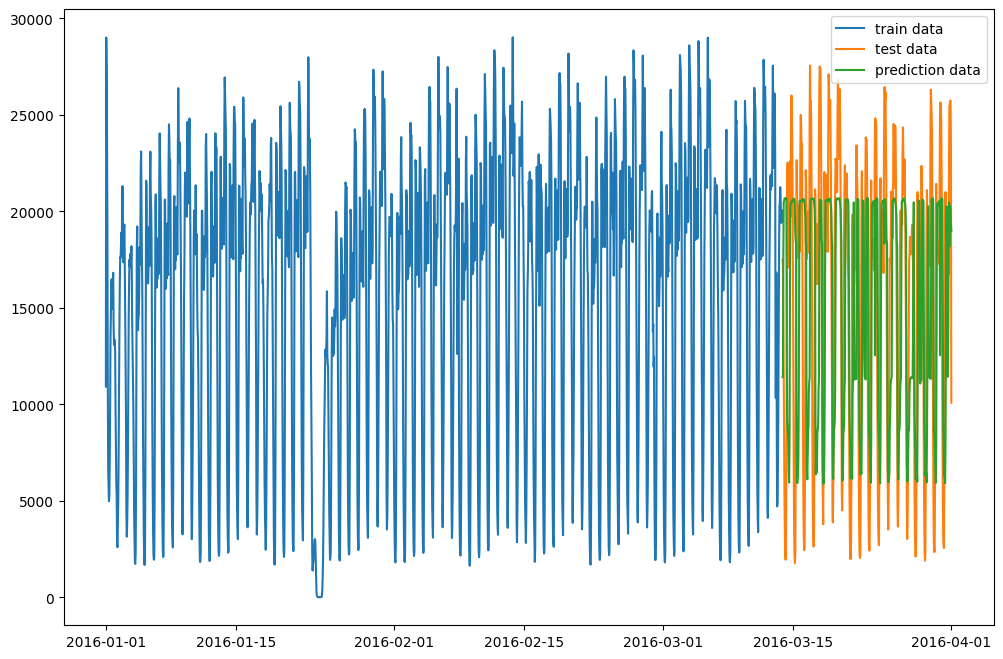

RMSE on validation data: 7463.776761104448


In [33]:
#Step4-2-4: Define the final LSTM model
#This is a 2 layers LSTM model
model_final2 = tuner2.get_best_models(num_models=1)[0]
model_final2.fit(trainX, trainY, epochs=300, batch_size=128, verbose=0)

#Step4-2-5: Veification the final model on validation data
#Because the model looks back 60 time periods, we need the last 100 rows of train data to predict the first 100 rows of test data.
tem=trainX[-101:]
new_testX=np.concatenate((tem,testX),axis=0)

testY_predict2=model_final2.predict(new_testX)
testY_predict2=[ i[0] for i in testY_predict2]
print()
plt.figure(figsize=(12,8))
plt.plot(train,label='train data')
plt.plot(test,label='test data')
plt.plot(pd.Series(testY_predict2,index=test.index),label='prediction data')
plt.legend()
plt.show()

#Step4-2-6: Calculate the MSE
import math
test_rmse2=math.sqrt(mean_squared_error(test,testY_predict2))
print('RMSE on validation data: {}'.format(test_rmse2))

The final LSTM model in general **performs poorly**. It can only captures **the low points** and is **really bad at capturing the peaks**. Next, I will use **the prediction of the LSTM model as the additional regressor of the FB Prophet model and hope that the ensemble model could inherit final LSTM model's ability at capturing the low points of the time series**. 

In [34]:
#Step7: Save the model
model_final.save('/Users/haochunniu/Desktop/Kaggle Compatition/NY Taxi Demand Forecast/Final LSTM Model')

INFO:tensorflow:Assets written to: /Users/haochunniu/Desktop/Kaggle Compatition/NY Taxi Demand Forecast/Final LSTM Model/assets


INFO:tensorflow:Assets written to: /Users/haochunniu/Desktop/Kaggle Compatition/NY Taxi Demand Forecast/Final LSTM Model/assets


In [8]:
#How to load model? Use code below
model_final = keras.models.load_model('/Users/haochunniu/Desktop/Kaggle Compatition/NY Taxi Demand Forecast/Final LSTM Model')
#model.predict(...)

2022-12-28 08:37:58.834187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### FB Prophet model with LSTM forecast as additional regressor ###
Lastly, I will try the FB Prohpet model and use the output of the LSTM model as an additional regressor. In addition, given that the FB Prophet model has built-in time-based cross validation function, I will use time-based cross validation to perform hyperparameter tuning. 

----------------------------------------------------------------------------------------------------------------------------------------------------
The entire process could be concluded into the following steps.

**Step1: Reshape the input time series for FB Prophet model**  
**Step2: Add output of the LSTM model as an additional regressor of the Prophet model**  
**Step3: Use built-in time-based cross validation to tune hyper-parameters**   
**Step4: Build the final model with the best hyper-parameters combination**  
**Step5: Predict on the test data and evaluate the model performance** 

In [30]:
from prophet import Prophet
from prophet.diagnostics import cross_validation

In [31]:
#Step1: FB Prophet model only inputs dataframe with 2 columns ds and y
train_pro = train.reset_index()
train_pro = train_pro.rename(columns={'index':'ds','cnt':'y'})

test_pro = test.reset_index()
test_pro = test_pro.rename(columns={'index':'ds','cnt':'y'})

In [32]:
#Step2: Add output of LSTM model as additional regressor. 
#Given that the LSTM model does not use the first 30 records of the train data, I will exclude the first 30 records of train data.
train_pro = train_pro.iloc[30:-1,:].reset_index(drop=True)

#Get the forecast of the LSTM model
LSTM_pred_train = model_final.predict(trainX)
LSTM_pred_train=[ i[0][0] for i in LSTM_pred_train]
LSTM_pred_test = testY_predict

#Add additional regressor into dataframe
train_pro['LSTM_pred'] = LSTM_pred_train
test_pro['LSTM_pred'] = LSTM_pred_test

54/54 [==============================] - 1s 10ms/step


In [42]:
#Step3: Use cross validation for hyper-parameter tuning
from prophet.diagnostics import performance_metrics
param_grid = { 'changepoint_prior_scale': [0.01,0.05,0.1,0.5],
               'daily_seasonality':[5,10],
               'weekly_seasonality':[5,10,20],
               'yearly_seasonality':[5,10]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    prophet_model = Prophet(**params) # Create model with hyper-parameter
    prophet_model.add_regressor('LSTM_pred') # Add the additional regressor
    prophet_model.add_seasonality(name='daily',period=6,fourier_order=8) # This is actually a six hours seasonality. Because Prophet only accept 3 types of seasonality (daily, weekly, yearly), I use daily seasonality to represent.
    prophet_model.add_seasonality(name='weekly',period=12,fourier_order=12) # This is actually a 12 hours seasonality. Because Prophet only accept 3 types of seasonality (daily, weekly, yearly), I use weekly seasonality to represent.
    prophet_model.add_seasonality(name='yearly',period=24,fourier_order=10) # This is actually a daily seasonality. Because Prophet only accept 3 types of seasonality (daily, weekly, yearly), I use yearly seasonality to represent.
    prophet_model = prophet_model.fit(train_pro)  # Fit model
    pro_cv = cross_validation(prophet_model, initial='180 hours', period='60 hours', horizon = '60 hours')
    df_performance = performance_metrics(pro_cv, rolling_window=1)
    rmses.append(df_performance['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:33:46 - cmdstanpy - INFO - Chain [1] start processing
14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:47 - cmdstanpy - INFO - Chain [1] start processing
14:33:47 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:49 - cmdstanpy - INFO - Chain [1] start processing
14:33:49 - cmdstanpy - INFO - Chain [1] done processing
14:33:49 - cmdstanpy - INFO - Chain [1] start processing
14:33:49 - cmdstanpy - INFO - Chain [1] done pro

    changepoint_prior_scale  daily_seasonality  weekly_seasonality  \
0                      0.01                  5                   5   
1                      0.01                  5                   5   
2                      0.01                  5                  10   
3                      0.01                  5                  10   
4                      0.01                  5                  20   
5                      0.01                  5                  20   
6                      0.01                 10                   5   
7                      0.01                 10                   5   
8                      0.01                 10                  10   
9                      0.01                 10                  10   
10                     0.01                 10                  20   
11                     0.01                 10                  20   
12                     0.05                  5                   5   
13                  

In [46]:
# Show the top 3 hyper-parameter combinations
tuning_results.sort_values(['rmse']).head(3).reset_index(drop=True)

,changepoint_prior_scale,daily_seasonality,weekly_seasonality,yearly_seasonality,rmse
0,0.01,10,20,5,3517.422138
1,0.01,5,20,5,3607.103856
2,0.05,10,20,5,3811.483922


In [48]:
#Step4: Build the final Prophet model based on the best hyper-parameter combination
prophet_model_final = Prophet(changepoint_prior_scale = 0.01,
                        daily_seasonality = 10,
                        weekly_seasonality = 20,
                        yearly_seasonality = 5)
prophet_model_final.add_seasonality(name='daily',period=24,fourier_order=10)
prophet_model_final.add_seasonality(name='halfdaily',period=12,fourier_order=12) #Important
prophet_model_final.add_seasonality(name='sixhourly',period=6,fourier_order=8)
prophet_model_final.add_regressor('LSTM_pred')
prophet_model_final = prophet_model_final.fit(train_pro) 

15:02:24 - cmdstanpy - INFO - Chain [1] start processing
15:02:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE on test data: 2614.644503879432


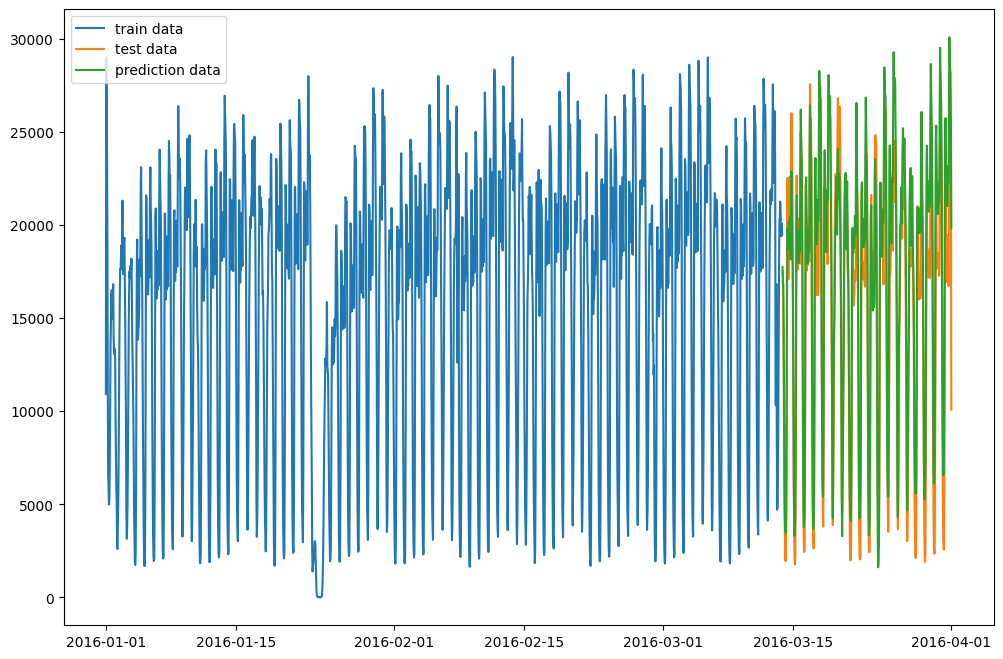

In [49]:
#Step5: Predict on test data and evaluate performance
fcst = prophet_model_final.predict(test_pro[['ds','LSTM_pred']])
print('RMSE on test data: {}'.format(math.sqrt(mean_squared_error(test,fcst['yhat']))))
plt.figure(figsize=(12,8))
plt.plot(train,label='train data')
plt.plot(test,label='test data')
plt.plot(fcst[['ds','yhat']].set_index('ds')['yhat'],label='prediction data')
plt.legend()
plt.show()

### Conclusion ###
Eventually, the ensemble model of FB Prophet and LSTM does a decent job. The **RMSE on test data is around 2614** which is pretty small. In addition, according to the plot above, the final model **captures the ups and downs of the time series well**.